# FFT mit Python's numpy: Rechne, skaliere und schiebe
In diesem Notebook wird gezeigt, wie man die FFT skaliert und verschiebt, so dass man direkt Amplituden und Frequenzen des analysierten Signals ablesen kann. Das wird gezeigt für einseitige und zweiseitige Spektren.

In [4]:
from __future__ import print_function, division
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
    
import matplotlib.pyplot as plt
plt.style.use("../presentation.mplstyle")
%matplotlib inline
import dsp_fpga_lib as dsp # import and set plot properties
import numpy as np

np.set_printoptions(threshold=20) # for > 20 items, print with (1,2, ... , 99, 100)
import scipy.signal as sig

plt.rcParams["figure.figsize"] = [14, 3]

## Testsignal
Um die Funktionsweise der DFT / FFT in numpy zu testen, erzeugen wir ein Testsignal $x$ mit zwei Tönen der Frequenzen $f_1$ und $f_2$ und den Amplituden $A_1$ bzw. $A_2$, abgetastet mit $f_S$. Unser Ziel ist, die FFT so zu berechnen, dass wir Amplituden und Frequenzen korrekt aus der FFT zurücklesen können.

In [5]:
N = 20 # number of DFT points
f_S = 20.0 # Sampling frequency in Hz
f_1 = 2.0; f_2 = 5 # Hz
A_1 = 8; A_2 = 3
DC = 0.75
t = np.linspace(0.0, N / f_S, num = N, endpoint=False)
x = A_1 * np.sin(2 * np.pi * f_1 * t) + A_2 * np.sin(2 * np.pi * f_2 * t) + DC
print(x)

[ 0.75        8.45228202  8.35845213  5.35845213  5.45228202  3.75
 -3.95228202 -9.85845213 -6.85845213 -0.95228202  0.75        2.45228202
  8.35845213 11.35845213  5.45228202 -2.25       -3.95228202 -3.85845213
 -6.85845213 -6.95228202]


## Anzeige des Zeitsignals

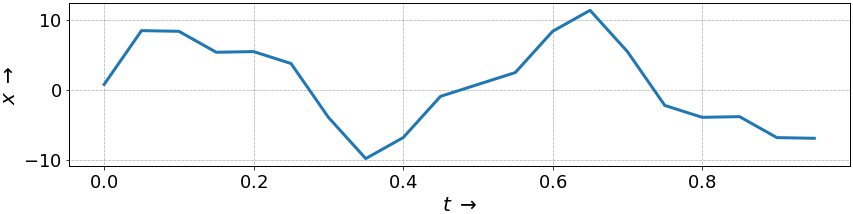

In [6]:
plt.plot(t, x)
plt.xlabel(r"$t \; \rightarrow$")
plt.ylabel(r"$x \; \rightarrow$"); # semicolon suppresses status message

## Berechnung der FFT
Wir berechnen die FFT mit `np.fft.fft(x)` und schauen was passiert:

/home/muenker/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


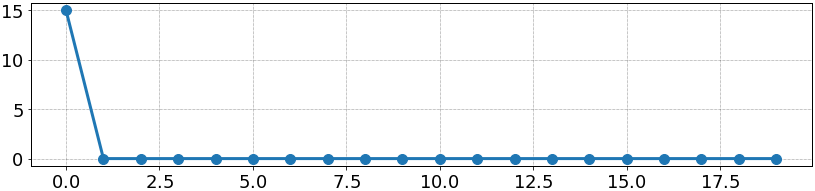

In [7]:
fft_x = np.fft.fft(x)
plt.plot(fft_x, 'o-');

Das Ergebnis der FFT ist bis auf einen Gleichanteil ($n = 0$) gleich Null - das ist unerwartet. Außerdem wird eine Warnung ausgegeben "casting complex values to real" - wir haben anscheinend versucht, komplexe Werte zu plotten, es wird aber nur der Realteil verwendet. Zeit, sich das Ergebnis der FFT genauer anzuschauen. Versuchen Sie die Syntax der Print-Formatierung nachzuvollziehen; 'g' spezifiziert eine Zahl im wissenschaftlichen Format.

In [8]:
def rround(x):
    """Round numbers to 8 decimals, eliminate near-zero imaginary parts. We loop over the array because using
    real_if_close() on an array only returns real if ALL elements are nearly real."""
    return np.around(np.real_if_close(x, tol=1e4), decimals=8)

for i in range(N//2):
    print("{0}\t{1:25.5g}\t{2}\t{3:25.5g}".format(i, (rround(fft_x[i])), N//2 + i, rround(fft_x[N//2 + i])))

0	                       15	10	                       -0
1	                       -0	11	                       -0
2	                   -0-80j	12	                        0
3	                       -0	13	                       -0
4	                       -0	14	                       -0
5	                    0-30j	15	                    0+30j
6	                       -0	16	                       -0
7	                       -0	17	                       -0
8	                        0	18	                    0+80j
9	                        0	19	                       -0


## Get Real!
Tatsächlich sind hier fast alle FFT-Bins bis auf vier (die sind imaginär) fast gleich Null. Bei einer FFT sollte man daher den Betrag (Betragsspektrum) bzw. Betrag und Phase plotten oder separat Real- und Imaginärteil:

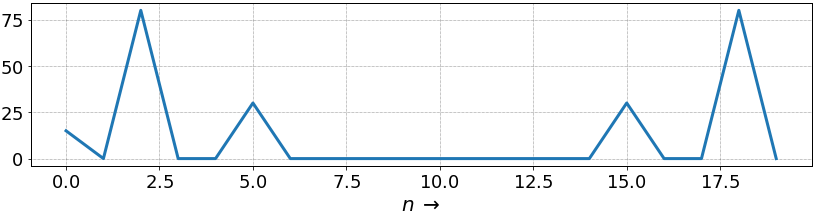

In [9]:
plt.plot(np.abs(fft_x))
plt.xlabel(r"$n\;\rightarrow$");

Das sieht schon besser aus, aber die Skalierung von Amplitude und Frequenz ist noch falsch. Die Frequenzachse ist einfach der Index $n=0 \ldots N_{FFT} - 1$, der die Frequenzen $f_n = 0, f_S/N,  \ldots,  f_S - f_S/N$ repräsentiert. Zur Umrechnung der Indexvariablen in die Frequenz kann man entweder selbst mit $f_S / N$ skalieren oder man verwendet die Hilfsfunktion `fftfreq()`, die außerdem die Reihenfolge der Bins ändert: Startend bei $f=0$ werden die Frequenzpunkte bis $f_S/2$ hochgezählt, danach geht es von $-f_S/2$ weiter bis (fast) zu Null Hz. Drucken Sie das Ergebnis von `fftfreq()` selbst aus, um das zu überprüfen. 

Damit die Amplitude der FFT-Bins der Amplitude der Sinustöne im Zeitbereich entspricht, muss durch die Anzahl der FFT-Punkte dividiert werden.

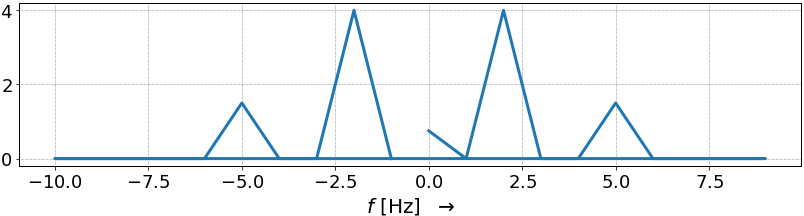

In [10]:
f = np.fft.fftfreq(N, 1/f_S) # calculate frequency points
plt.plot(f, np.abs(fft_x)/N)
plt.xlabel(r"$f$ [Hz]  $\rightarrow$");

## Vertauschen von pos. und neg. Frequenzen
Die falsche Reihenfolge von neg. und pos. Frequenzen kann man an der durchgezogenen Nulllinie erkennen - hier springt der Plot von der höchsten zur niedrigsten Frequenz zurück. Das ist besonders unschön, wenn die Amplitude bei diesen beiden Frequenzen verschieden von Null ist, dann geht ein Strich quer durchs Bild (probieren Sie es selbst aus, indem Sie eine "schräge" Kombination aus Signal- und Abtastfrequenzen wählen, bei der man keine ganze Anzahl von Signalperioden im Messfenster erhält.

Zum Vertauschen der beiden Frequenzhälften im Frequenzvektor gibt es die Hilfsfunktion `fftshift()`:

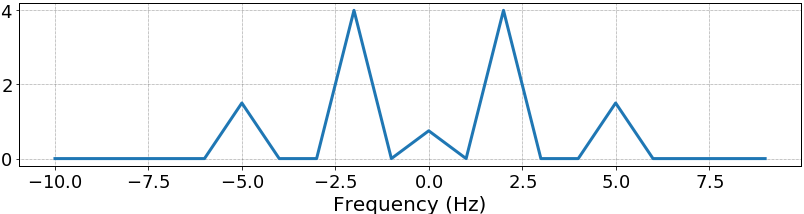

In [11]:
fft_x_shifted = np.fft.fftshift(fft_x) / N
f_shifted = np.fft.fftshift(f)
plt.plot(f_shifted, np.abs(fft_x_shifted))
plt.xlabel("Frequency (Hz)");

Da Spektralanteile bei positiven und negativen Frequenzen dargestelt sind, sind die Amplituden der Töne nur halb so groß wie im Zeitbereich. 

## Einseitiges Spektrum
Vor allem bei reellwertigen Zeitsignalen stellt man normalerweise nur die erste Hälfte der (unverschobenen) FFT über der ersten Hälfte des Frequenzvektors dar. Damit die Amplituden korrekt sind, muss der Wert aller Bins verdoppelt werden (außer dem bei DC, $n=0$). 

In [12]:
half_n = N//2 # needs to be integer for indexing
fft_x_half = (2.0 / N) * fft_x[:half_n]
fft_x_half[0] /= 2
f_half = f[:half_n]

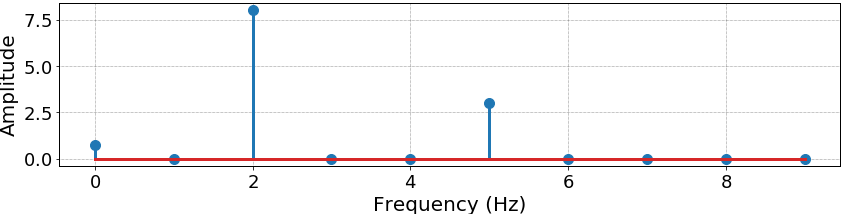

In [13]:
plt.stem(f_half, np.abs(fft_x_half))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude");

Jetzt stimmen Amplituden und Frequenzen mit dem überein, was wir aus dem Zeitbereich erwarten würden. Die FFT ist als Stem-Plot dargestellt, um daran zu erinnern dass die FFT nur diskrete Frequenzpunkte liefert.

## Fragen und Aufgaben
- Generieren Sie zwei Sinussignale 

<hr>
**Copyright**

(c) 2016 - 2018 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digitale Signalverarbeitung auf FPGAs"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2018*.